<h2>Библиотеки</h2>

Failed to retrieve data. HTTP Status code: 401


In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt

In [24]:
def to_numeric_with_exceptions(column):
    try:
        return pd.to_numeric(column)
    except ValueError:
        return column

def add_rows(df):
    new_rows = []
    for name, group in df.groupby(['Year', 'Month', 'Day']):
        if len(group) != 8:
            missing_hours = [hour for hour in range(0, 24, 3) if hour not in group['Hour'].values]

            for hour in missing_hours:
                new_row = {col: np.nan for col in df.columns}
                new_row['Year'] = name[0]
                new_row['Month'] = name[1]
                new_row['Day'] = name[2]
                new_row['Hour'] = hour
                new_rows.append(new_row)

    if new_rows:
        new_rows_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_rows_df], ignore_index=True)
        df.sort_values(by=['Year', 'Month', 'Day', 'Hour'], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return df

<h2>Данные</h2>

Прочтем наш датасет по атрибутам: даты, обязательных параметров погоды и не обязательных, описательных ее частей

In [25]:
df = pd.read_csv('DataBase.csv',
                 delimiter=';',
                 names = ['Year', 'Month', 'Day', 'Hour', #date parameters
                          'Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness', #necessary parameters
                          'Weather', 'LowCl', 'LowPerc', 'Height', 'HighCl1', 'HighCl2', 'Visibility', 'Rainfall'], #unnecessary parameters
                 low_memory=False)

<h2>Обработка и очистка данных</h2>

<h4>Описание функций</h4>

Опишем функции очистки данных и добавления пропадающих временных рядов

In [26]:
def to_numeric_with_exceptions(column):
    try:
        return pd.to_numeric(column)
    except ValueError:
        return column

def add_rows(df):
    new_rows = []
    for name, group in df.groupby(['Year', 'Month', 'Day']):
        if len(group) != 8:
            missing_hours = [hour for hour in range(0, 24, 3) if hour not in group['Hour'].values]

            for hour in missing_hours:
                new_row = {col: np.nan for col in df.columns}
                new_row['Year'] = name[0]
                new_row['Month'] = name[1]
                new_row['Day'] = name[2]
                new_row['Hour'] = hour
                new_rows.append(new_row)

    if new_rows:
        new_rows_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_rows_df], ignore_index=True)
        df.sort_values(by=['Year', 'Month', 'Day', 'Hour'], inplace=True)
        df.reset_index(drop=True, inplace=True)

    return df

<h3>Заполнение пропущенных значений и очистка данных</h3>

Преобразуем выдуманные единицы направления воздуха в угловые направления 

<img src="Роза ветров.png" width="500">

In [27]:
direction_mapping = {
    0: 0,
    1: 90,
    2: 60,
    3: 45,
    4: 30,
    5: 360,
    6: 330,
    7: 315,
    8: 300,
    9: 270,
    10: 240,
    11: 225,
    12: 210,
    13: 180,
    14: 150,
    15: 135,
    16: 120 
}

df['Direction'] = df['Direction'].map(direction_mapping)

df['Direction'].head(10)

0    315.0
1    315.0
2    315.0
3    315.0
4    315.0
5    330.0
6    315.0
7    315.0
8    315.0
9    315.0
Name: Direction, dtype: float64

Соответственно проведем преобразования: 

- Уберем лишние текстовые значения
- Добавим недостающие пропущенные строки временного интервала
- Заполним обязательные их поля
- Уберем первую нулевую строчку
- Преобразуем все атрибуты в их типы

In [28]:
df['Visibility'] = df['Visibility'].replace('менее 0.1','0')
df['Rainfall'] = df['Rainfall'].replace('Следы осадков','0.05')

In [31]:
df=add_rows(df)

columns_to_fill = ['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']
df[columns_to_fill] = df[columns_to_fill].ffill()

df = df[1:len(df)]

for col in df.columns:
    df[col] = to_numeric_with_exceptions(df[col])

df.head(8)

,Year,Month,Day,Hour,Temp,Pressure,Humidity,Direction,Power,Cloudiness,Weather,LowCl,LowPerc,Height,HighCl1,HighCl2,Visibility,Rainfall
1,2005,2,1,3,-8.6,743.0,89.0,315.0,2.0,100.0,Снег,Слоисто-кучевые,75.0,800.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN
2,2005,2,1,6,-8.2,742.8,90.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,2.0
3,2005,2,1,9,-8.6,743.5,89.0,315.0,3.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,100.0,450.0,Высокослоистые просвечивающие.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4.0,3.0
4,2005,2,1,12,-7.1,745.0,85.0,315.0,3.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,10.0,NaN
5,2005,2,1,15,-6.6,746.8,83.0,315.0,3.0,100.0,Ливень,Кучевые средние,100.0,450.0,Высококучевые башенкообразные или хлопьевидные.,"Перисто-кучевые одни или перисто-кучевые, сопр...",4.0,NaN
6,2005,2,1,18,-7.9,748.7,87.0,330.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,NaN
7,2005,2,1,21,-8.9,750.0,83.0,315.0,2.0,95.0,Снег,Слоисто-кучевые,95.0,800.0,NaN,NaN,NaN,1.0
8,2005,2,2,0,-9.1,751.0,85.0,315.0,2.0,100.0,Снег,Слоистые разорванные или кучевые разорванные о...,75.0,450.0,NaN,"Перисто-кучевые одни или перисто-кучевые, сопр...",NaN,NaN


Запишем измененный датасет внутрь файла Temp.csv

In [32]:
df = ps.sqldf("""SELECT Year, Month, Day, AVG(Temp) AS Temp, AVG(Pressure) AS Pressure, AVG(Humidity) AS Humidity, AVG(Direction)AS Direction, AVG(Power) AS Power, AVG(Cloudiness) AS Cloudiness
                     FROM df
                     GROUP BY Year,Month,Day"""
               ,locals())

In [33]:
df.to_csv('Temp.csv', sep=';')

<h4>Нормализация данных</h4>

In [17]:
df_avg = ps.sqldf("""SELECT Year, Month, Day, AVG(Temp) AS Temp, AVG(Pressure) AS Pressure, AVG(Humidity) AS Humidity, AVG(Direction)AS Direction, AVG(Power) AS Power, AVG(Cloudiness) AS Cloudiness
                     FROM df
                     GROUP BY Year,Month,Day"""
               ,locals())
df_avg['Date'] = pd.to_datetime(df_avg[['Year', 'Month', 'Day']])
df_avg.set_index('Date', inplace=True)
df_avg.drop(columns=['Year', 'Month', 'Day'], inplace=True)

df_std = df

df_avg

# features_to_normalize = ['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness','LowPerc','Height', 'Visibility','Rainfall']
# scaler = StandardScaler()
# df_std[features_to_normalize] = scaler.fit_transform(df_std[features_to_normalize])

,Temp,Pressure,Humidity,Direction,Power,Cloudiness
Date,,,,,,
2005-02-01,-7.985714,745.685714,86.571429,317.142857,2.571429,97.857143
2005-02-02,-9.462500,754.662500,83.875000,318.750000,1.875000,90.000000
2005-02-03,-13.012500,763.212500,80.625000,238.125000,0.875000,26.250000
2005-02-04,-14.912500,767.562500,78.625000,0.000000,0.000000,11.250000
2005-02-05,-16.012500,767.612500,88.375000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
2023-03-30,4.412500,743.887500,85.625000,210.000000,1.125000,99.375000
2023-03-31,0.662500,742.012500,85.000000,91.875000,1.750000,99.375000
2023-04-01,3.850000,739.850000,81.625000,123.750000,0.625000,93.750000


Раскатегоризируем столбец погоды и различных облаков под модель

In [18]:
enc = OneHotEncoder()
df_std = df_std.reset_index(drop=True)
df_std = df_std[['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']]

df_std_Weather = pd.DataFrame(enc.fit_transform(df[['Weather']]).toarray())
encoded_columns = enc.get_feature_names_out(['Weather'])
df_std_Weather.columns = encoded_columns

df_std_LowCl = pd.DataFrame(enc.fit_transform(df[['LowCl']]).toarray())
encoded_columns = enc.get_feature_names_out(['LowCl'])
df_std_LowCl.columns = encoded_columns

df_std_HighCl1 = pd.DataFrame(enc.fit_transform(df[['HighCl1']]).toarray())
encoded_columns = enc.get_feature_names_out(['HighCl1'])
df_std_HighCl1.columns = encoded_columns

df_std_HighCl2 = pd.DataFrame(enc.fit_transform(df[['HighCl2']]).toarray())
encoded_columns = enc.get_feature_names_out(['HighCl2'])
df_std_HighCl2.columns = encoded_columns

df_std = df_std[['Temp', 'Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']].join(df_std_Weather).join(df_std_LowCl).join(df_std_HighCl1).join(df_std_HighCl2)
df_std.head(3)

,Temp,Pressure,Humidity,Direction,Power,Cloudiness,Weather_Алмазная пыль,Weather_Ветер,Weather_Град,Weather_Гроза,...,"HighCl2_Перисто-слоистые, не распространяющиеся по небу и не покрывающие его полностью.","HighCl2_Перисто-слоистые, покрывающие все небо.","HighCl2_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся, но сплошная пелена поднимается над горизонтом менее чем на 45°.","HighCl2_Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся; сплошная пелена, поднимающаяся над горизонтом выше 45°, не покрывает всего неба.","HighCl2_Перистые когтевидные или нитевидные или первые и вторые, распространяющиеся по небу и в целом обычно уплотняющиеся.","HighCl2_Перистые нитевидные, иногда когтевидные, не распространяющиеся по небу.","HighCl2_Перистые плотные в виде клочьев или скрученных склонов, количество которых обычно не увеличивается, иногда могут казаться остатками верхней части кучево-дождевых; или перистые башенкообразные, или перистые хлопьевидные.","HighCl2_Перистые плотные, образовавшиеся от кучево-дождевых.","HighCl2_Перистых, перисто-кучевых или перисто-слоистых нет.",HighCl2_nan
0,-8.6,743.0,89.0,315.0,2.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.2,742.8,90.0,315.0,3.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-8.6,743.5,89.0,315.0,3.0,100.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3> Разделение данных на обучающую и тестовую выборки </h3>


In [19]:
column_indices = {name: i for i, name in enumerate(df_std.columns)}

n = len(df_std)
train_df = df_std[0:int(n*0.7)]
val_df = df_std[int(n*0.7):int(n*0.9)]
test_df = df_std[int(n*0.9):]

num_features = df_std.shape[1]


<h2>Анализ данных</h2>

<h4>Анализ сезонности и трендов</h4>

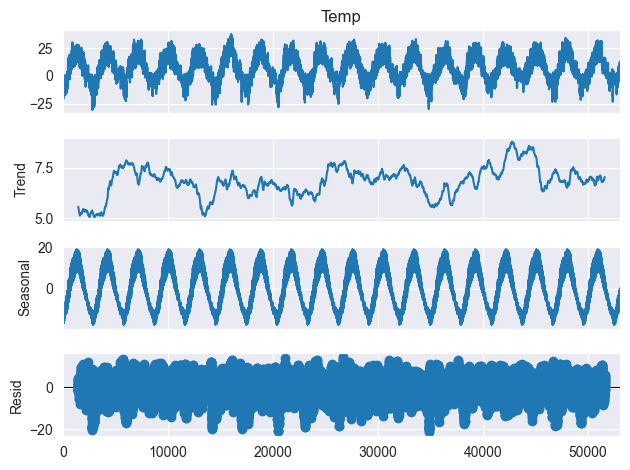

In [15]:
decomposition = seasonal_decompose(df_std['Temp'], model='additive', period=365*8)

decomposition.plot()

plt.show()

<h4>Статистические характеристики временных рядов</h4>

Оценим температуру и опишем скошенность и выбросы хвостов 

In [16]:
print(df_std.describe())

print(f"Скошенность: {df_std['Temp'].skew()}")
print(f"Выбросы: {df_std['Temp'].kurt()}")

               Temp      Pressure      Humidity     Direction         Power  \
count  53071.000000  53071.000000  53071.000000  53071.000000  53071.000000   
mean       6.719966    747.566790     75.996947    144.520171      1.166381   
std       10.819880      7.567347     17.735161    117.410968      0.951122   
min      -30.500000    712.200000     12.000000      0.000000      0.000000   
25%       -0.800000    742.900000     65.000000      0.000000      0.000000   
50%        6.400000    747.500000     81.000000    135.000000      1.000000   
75%       15.200000    752.200000     90.000000    240.000000      2.000000   
max       37.800000    778.200000    100.000000    360.000000      8.000000   

         Cloudiness  Weather_Алмазная пыль  Weather_Ветер  Weather_Град  \
count  53071.000000           53071.000000   53071.000000  53071.000000   
mean      70.953628               0.000565       0.000019      0.001658   
std       38.003324               0.023769       0.004341      

<h4>Корреляционный анализ</h4>

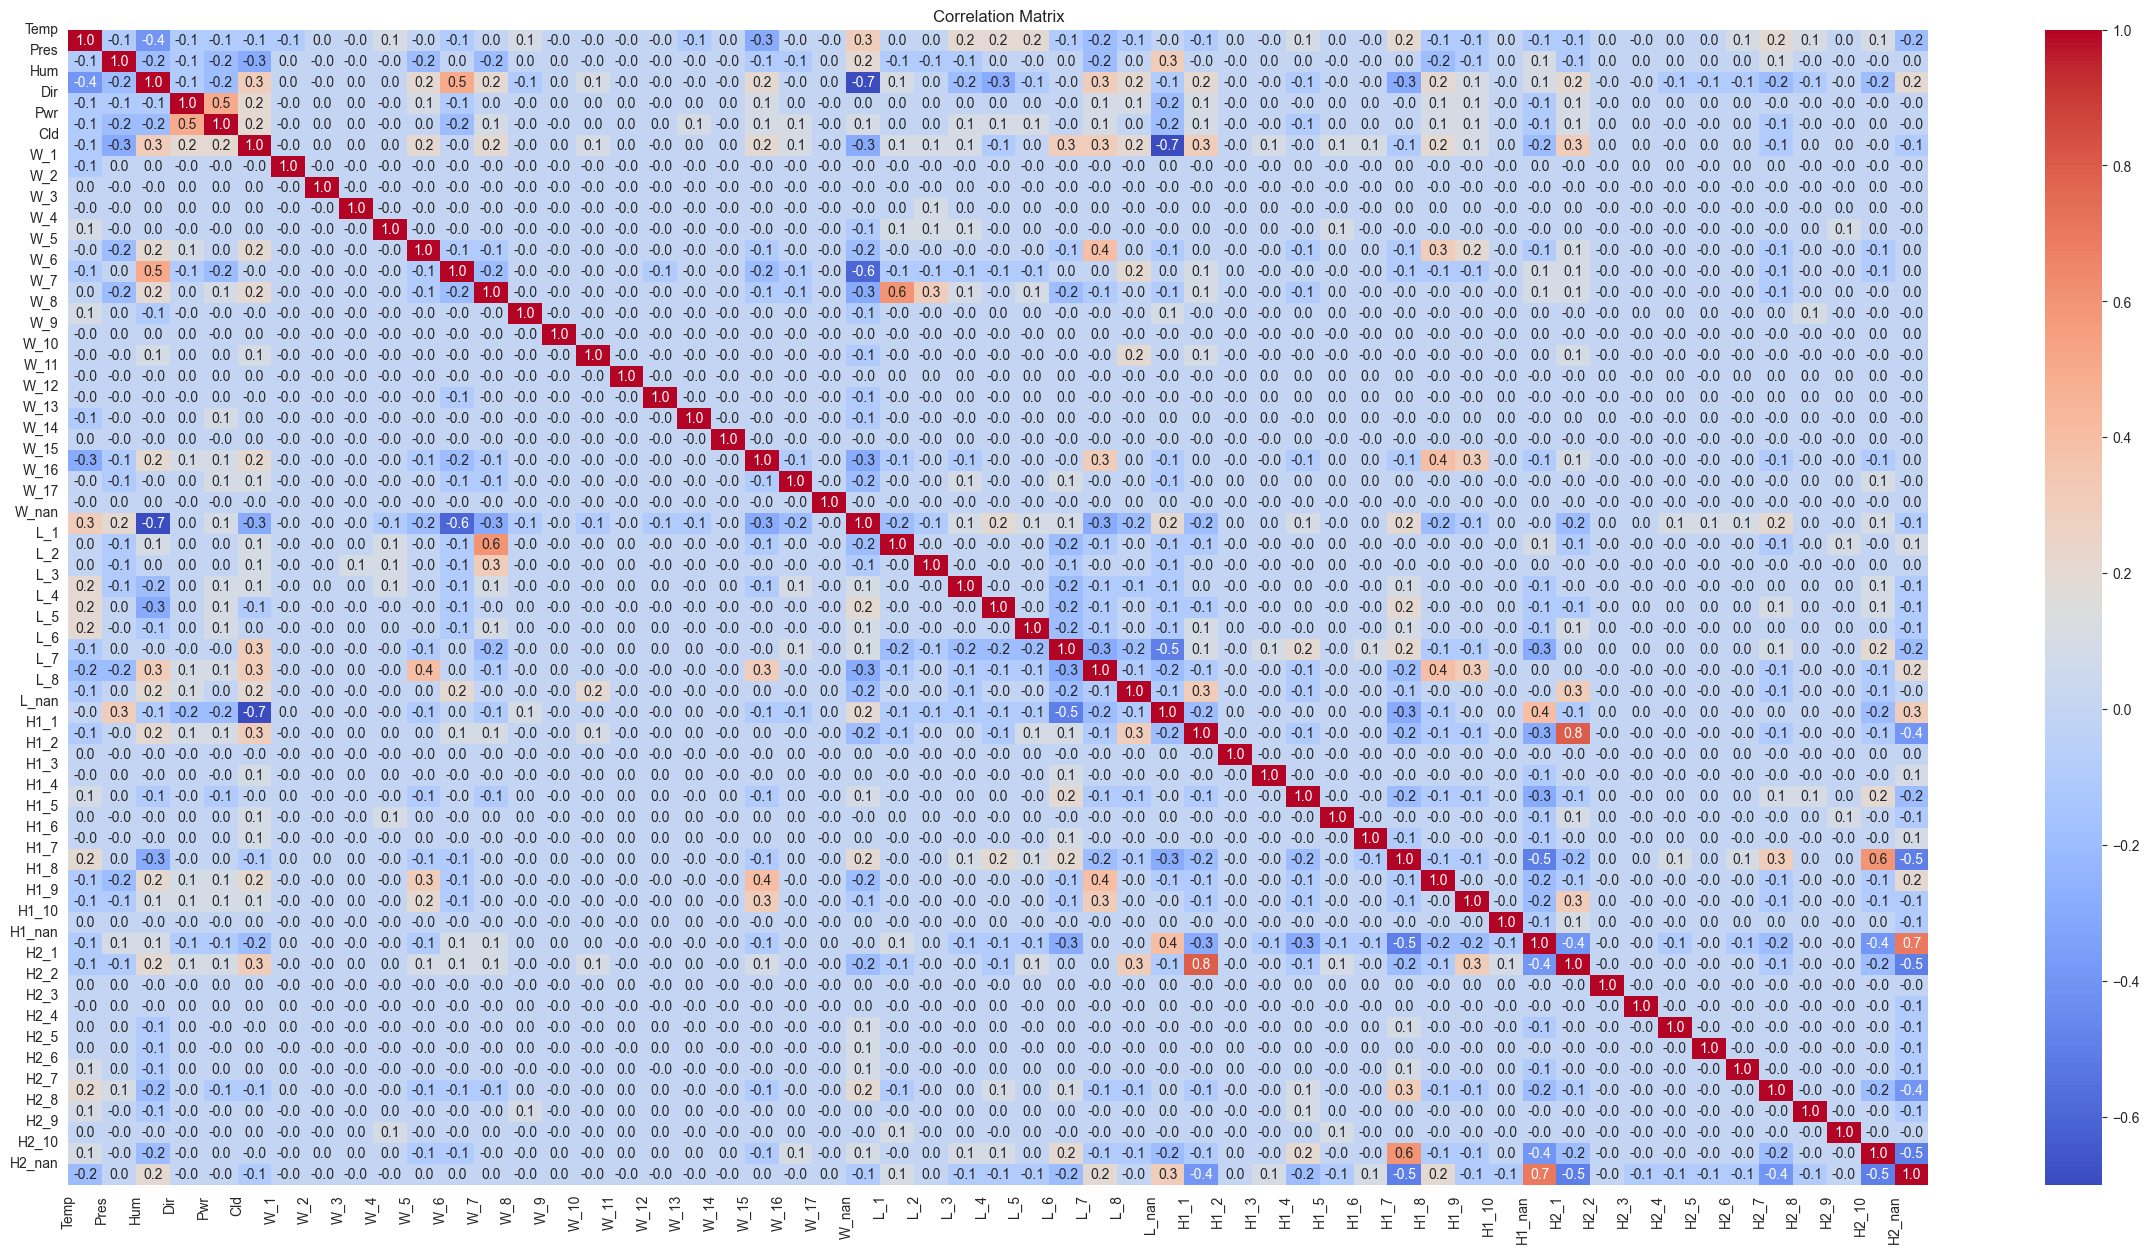

In [17]:
plt.figure(figsize=(30, 15))
sns.heatmap(df_std.corr().round(1), annot=True, cmap='coolwarm', fmt='.1f')

short_column_names = ['Temp', 'Pres', 'Hum', 'Dir', 'Pwr', 'Cld',  #6
                      'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', #10
                      'W_11', 'W_12', 'W_13', 'W_14', 'W_15', 'W_16', 'W_17', 'W_nan',#8
                      'L_1', 'L_2', 'L_3', 'L_4', 'L_5', 'L_6', 'L_7', 'L_8', 'L_nan', #9
                      'H1_1', 'H1_2','H1_3' ,'H1_4','H1_5','H1_6','H1_7','H1_8','H1_9','H1_10','H1_nan',#11
                      'H2_1', 'H2_2','H2_3' ,'H2_4','H2_5','H2_6','H2_7','H2_8','H2_9','H2_10','H2_nan'] #11

plt.xticks(ticks=range(0, len(df_std.columns), 1), labels=short_column_names[::1], rotation=90)
plt.yticks(ticks=range(0, len(df_std.columns), 1), labels=short_column_names[::1], rotation=0)


plt.title('Correlation Matrix')
plt.show()

<h2> Моделирование</h2>

In [18]:
# print('Результат теста:')
# df_result = adfuller(df_std['Humidity'])
# df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
# for result_value, label in zip(df_result, df_labels):
#     print(label + ' : ' + str(result_value))
#
# if df_result[1] <= 0.05:
#     print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
# else:
#     print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")

Найдем значения p - AR, d - I, q - MA порядков модели  

In [19]:
# df_std['Temp_diff'] = df_std['Temp'].diff().dropna()
#
# # Определение параметров ARIMA с использованием ACF и PACF
# lag_acf = acf(df_std['Temp_diff'].dropna(), nlags=20)
# lag_pacf = pacf(df_std['Temp_diff'].dropna(), nlags=20)
#
# # Построение графиков ACF и PACF
# plt.figure(figsize=(12, 6))
# plt.subplot(121)
# plt.plot(lag_acf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(df_std['Temp_diff'].dropna())), linestyle='--', color='gray')
# plt.axhline(y=1.96/np.sqrt(len(df_std['Temp_diff'].dropna())), linestyle='--', color='gray')
# plt.title('Autocorrelation Function')
#
# # Partial Autocorrelation Function (PACF)
# plt.subplot(122)
# plt.plot(lag_pacf)
# plt.axhline(y=0, linestyle='--', color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(df_std['Temp_diff'].dropna())), linestyle='--', color='gray')
# plt.axhline(y=1.96/np.sqrt(len(df_std['Temp_diff'].dropna())), linestyle='--', color='gray')
# plt.title('Partial Autocorrelation Function')
# plt.tight_layout()
# plt.show()

Обучим модель и получим ее параметры:

In [20]:
# model = SARIMAX(train_df['Temp'], order=(2, 1, 2), seasonal_order=(0, 1, 2, 30))
# results = model.fit()
# print(results.summary())


In [21]:
# results.plot_diagnostics(figsize=(15, 10))
# plt.show()

In [22]:
# forecast = results.forecast(steps=30)
#
# # Рассчитываем MSE и MAE
# mse = mean_squared_error(train_df['Temp'][-30:], forecast)
# mae = mean_absolute_error(train_df['Temp'][-30:], forecast)
#
# print(f'MSE: {mse}')
# print(f'MAE: {mae}')

In [23]:
# forecast_future = results.get_forecast(steps=90)
# # Создаем диапазон дат для прогноза
#
# future_dates = pd.date_range(start=train_df.index.max(), periods=90, freq='D') + pd.DateOffset(days=1)
#
# # Создаем DataFrame для прогноза с датами в качестве индексов
# forecast_df = pd.DataFrame({'Прогноз температуры': forecast_future.predicted_mean})
# forecast_df['Дата'] = future_dates
# forecast_df.set_index('Дата', inplace=True)
#
# # Присоединяем прогноз к исходному DataFrame
# train_df = pd.concat([train_df, forecast_df])
#
# # Визуализация исходных данных и прогноза
# plt.figure(figsize=(12, 6))
# plt.plot(train_df.index[:-90], train_df['Temp'][:-90], label='Исходные данные')
# plt.plot(train_df.index[-90:], train_df['Прогноз температуры'][-90:], label='Прогноз', color='red')
# plt.title('Прогноз средней дневной температуры')
# plt.xlabel('Дата')
# plt.ylabel('Температура (°C)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [24]:
# val_forecast = results.forecast(steps=len(val_df))
# test_forecast = results.forecast(steps=len(test_df))
#
# # Визуализация прогноза
# plt.figure(figsize=(12, 6))
# plt.plot(df_std.index, df_std['Temp'], label='Actual')
# plt.plot(val_df.index, val_forecast, label='Validation Forecast', color='orange')
# plt.plot(test_df.index, test_forecast, label='Test Forecast', color='red')
# plt.legend()
# plt.title('Temperature Forecast')
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.show()
#
# # Оценка модели на тестовой выборке
# test_actual = test_df['Temp']
# mse = mean_squared_error(test_actual, test_forecast)
# r2 = r2_score(test_actual, test_forecast)
# print('Test MSE:', mse)
# print('Test R2:', r2)

In [25]:
# fig, axes = plt.subplots(3, 2, sharex=True)
#
# # График исходного ряда с графиком автокорреляции
# axes[0, 0].plot(train_df['Temp'])
# axes[0, 0].set_title('The Genuine Series')
# plot_acf(train_df['Temp'], ax=axes[0, 1])
#
# # Разность первого порядка с графиком автокорреляции
# axes[1, 0].plot(train_df['Temp'].diff())
# axes[1, 0].set_title('Order of Differencing: 1')
# plot_acf(train_df['Temp'].diff().dropna(), ax=axes[1, 1])
#
# # Разность второго порядка с графиком автокорреляции
# axes[2, 0].plot(train_df['Temp'].diff().diff())
# axes[2, 0].set_title('Order of Differencing: 2')
# plot_acf(train_df['Temp'].diff().diff().dropna(), ax=axes[2, 1])
#
# plt.tight_layout()
# plt.show()

gradient_descent_code = """
__global__ void compute_gradient(float *X, float *y, float *w, float *grad, int n, int d) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < d) {
        float gradient = 0;
        for (int j = 0; j < n; ++j) {
            float prediction = 0;
            for (int k = 0; k < d; ++k) {
                prediction += X[j * d + k] * w[k];
            }
            gradient += (prediction - y[j]) * X[j * d + i];
        }
        grad[i] = gradient / n;
    }
}
"""
mod = SourceModule(gradient_descent_code)
compute_gradient = mod.get_function("compute_gradient")

prediction_code = """
__global__ void predict(float *X, float *w, float *pred, int n, int d) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) {
        float prediction = 0;
        for (int j = 0; j < d; ++j) {
            prediction += X[i * d + j] * w[j];
        }
        pred[i] = prediction;
    }
}
"""

mod = SourceModule(prediction_code)
predict = mod.get_function("predict")

features = ['Pressure', 'Humidity', 'Direction', 'Power', 'Cloudiness']
target = 'Temp'

# Преобразуем данные в массивы numpy
X = train_df[features].values.astype(np.float32)
y = train_df[target].values.astype(np.float32)

print(y,X)

# Размерности
n, d = X.shape

# Инициализируем веса и градиенты
w = np.random.randn(d).astype(np.float32)
grad = np.zeros(d, dtype=np.float32)

# Выделение памяти на GPU
X_gpu = cuda.mem_alloc(X.nbytes)
y_gpu = cuda.mem_alloc(y.nbytes)
w_gpu = cuda.mem_alloc(w.nbytes)
grad_gpu = cuda.mem_alloc(grad.nbytes)

# Копирование данных на GPU
cuda.memcpy_htod(X_gpu, X)
cuda.memcpy_htod(y_gpu, y)
cuda.memcpy_htod(w_gpu, w)

# Гиперпараметры
learning_rate = 0.01
num_epochs = 10000
block_size = 256  # Количество потоков в блоке
grid_size = (d + block_size - 1) // block_size  # Количество блоков

for epoch in range(num_epochs):
    # Вычисление градиента на GPU
    compute_gradient(X_gpu, y_gpu, w_gpu, grad_gpu, np.int32(n), np.int32(d), block=(block_size, 1, 1), grid=(grid_size, 1))

    # Копирование градиента с GPU на CPU
    cuda.memcpy_dtoh(grad, grad_gpu)

    # Обновление весов
    w -= learning_rate * grad

# Копирование финальных весов с GPU на CPU
cuda.memcpy_dtoh(w, w_gpu)

print("Обученные веса:", w)


# Нормализация данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(train_df[features].values.astype(np.float32))
y_train = scaler_y.fit_transform(train_df[[target]].values.astype(np.float32)).flatten()

X_val = scaler_X.transform(val_df[features].values.astype(np.float32))
y_val = scaler_y.transform(val_df[[target]].values.astype(np.float32)).flatten()

X_test = scaler_X.transform(test_df[features].values.astype(np.float32))
y_test = scaler_y.transform(test_df[[target]].values.astype(np.float32)).flatten()



# Размерности данных
n_train, d = X_train.shape

# Инициализация весов и градиентов
w = np.random.randn(d).astype(np.float32)
grad = np.zeros(d, dtype=np.float32)

# Выделение памяти на GPU
X_train_gpu = cuda.mem_alloc(X_train.nbytes)
y_train_gpu = cuda.mem_alloc(y_train.nbytes)
w_gpu = cuda.mem_alloc(w.nbytes)
grad_gpu = cuda.mem_alloc(grad.nbytes)

# Копирование данных на GPU
cuda.memcpy_htod(X_train_gpu, X_train)
cuda.memcpy_htod(y_train_gpu, y_train)
cuda.memcpy_htod(w_gpu, w)

# Гиперпараметры
learning_rate = 0.01
num_epochs = 10000
block_size = 256
grid_size = (d + block_size - 1) // block_size

# Обучение модели
for epoch in range(num_epochs):
    compute_gradient(X_train_gpu, y_train_gpu, w_gpu, grad_gpu, np.int32(n_train), np.int32(d), block=(block_size, 1, 1), grid=(grid_size, 1))
    cuda.memcpy_dtoh(grad, grad_gpu)
    w -= learning_rate * grad

cuda.memcpy_dtoh(w, w_gpu)
print("Обученные веса:", w)


# Размерности тестовых данных
n_test = X_test.shape[0]

# Выделение памяти на GPU для новых данных и предсказаний
X_test_gpu = cuda.mem_alloc(X_test.nbytes)
pred_gpu = cuda.mem_alloc(X_test.shape[0] * np.dtype(np.float32).itemsize)

# Копирование новых данных на GPU
cuda.memcpy_htod(X_test_gpu, X_test)

# Запуск предсказаний на GPU
block_size = 256
grid_size = (n_test + block_size - 1) // block_size
pred = np.zeros(n_test, dtype=np.float32)
predict(X_test_gpu, w_gpu, pred_gpu, np.int32(n_test), np.int32(d), block=(block_size, 1, 1), grid=(grid_size, 1))

# Копирование предсказаний с GPU на CPU
cuda.memcpy_dtoh(pred, pred_gpu)

# Обратное масштабирование предсказаний
pred = scaler_y.inverse_transform(pred.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Вывод предсказаний
print("Предсказанные значения температуры:", pred)

# Оценка модели
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_inv, pred)
mae = mean_absolute_error(y_test_inv, pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')


In [20]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = [
    LinearRegression(),  # метод наименьших квадратов
    RandomForestRegressor(n_estimators=100, max_features='sqrt'),  # случайный лес
    KNeighborsRegressor(n_neighbors=6),  # метод ближайших соседей
    SVR(kernel='linear'),  # метод опорных векторов с линейным ядром
    LogisticRegression() # логистическая регрессия
]

In [21]:
from sklearn.model_selection import train_test_split

trg = df_std[['Temp','Pressure']]
trn = df_std.drop(['Temp','Pressure'], axis=1)

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)


In [22]:
# DataFrame to store the results
TestModels = pd.DataFrame()
# Evaluate each model
for model in models:
    model_name = model.__class__.__name__
    tmp = {'Model': model_name}
    for i in range(Ytrn.shape[1]):
        # Fit the model
        model.fit(Xtrn, Ytrn.iloc[:, i])
        # Predict
        predictions = model.predict(Xtest)

        r2 = r2_score(Ytest.iloc[:, i], predictions)
        tmp[f'R2_Y{i+1}'] = r2

    # Append the results to the DataFrame
    print(TestModels,tmp)

# Set the index to the model names
TestModels.set_index('Model', inplace=True)

Empty DataFrame
Columns: []
Index: [] {'Model': 'LinearRegression', 'R2_Y1': 0.3489777183808248, 'R2_Y2': 0.165903759364614}
Empty DataFrame
Columns: []
Index: [] {'Model': 'RandomForestRegressor', 'R2_Y1': 0.35332052466083885, 'R2_Y2': 0.12088310679596137}
Empty DataFrame
Columns: []
Index: [] {'Model': 'KNeighborsRegressor', 'R2_Y1': 0.25625583354086867, 'R2_Y2': 0.1110853232845237}
Empty DataFrame
Columns: []
Index: [] {'Model': 'SVR', 'R2_Y1': 0.3262178056374331, 'R2_Y2': 0.16011204406596413}


ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Предполагаем, что ваш DataFrame называется df_std
# df_std = pd.read_csv('your_data.csv') # Загрузите ваши данные здесь

# Определяем модели
models = [
    LinearRegression(),  # метод наименьших квадратов
    RandomForestRegressor(n_estimators=100, max_features='sqrt'),  # случайный лес
    KNeighborsRegressor(n_neighbors=6),  # метод ближайших соседей
    SVR(kernel='linear')  # метод опорных векторов с линейным ядром
]

# Определяем целевые и входные переменные
trg = df_std[['Humidity', 'Pressure']]
trn = df_std.drop(['Humidity', 'Pressure'], axis=1)

# Разделяем данные на обучающую и тестовую выборки
Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4, random_state=42)

# DataFrame для хранения результатов
TestModels = pd.DataFrame()

# Оцениваем каждую модель
for model in models:
    model_name = model.__class__.__name__
    tmp = {'Model': model_name}
    for i in range(Ytrn.shape[1]):
        # Обучаем модель
        model.fit(Xtrn, Ytrn.iloc[:, i])
        # Предсказываем
        predictions = model.predict(Xtest)
        # Вычисляем коэффициент детерминации R²
        r2 = r2_score(Ytest.iloc[:, i], predictions)
        tmp[f'R2_Y{i+1}'] = r2

    # Добавляем результаты в DataFrame
    print(tmp,TestModels)

# Устанавливаем индекс по названию модели
TestModels.set_index('Model', inplace=True)

print(TestModels)


{'Model': 'LinearRegression', 'R2_Y1': 0.6447172913474021, 'R2_Y2': 0.21022621683437814} Empty DataFrame
Columns: []
Index: []
{'Model': 'RandomForestRegressor', 'R2_Y1': 0.669826150013521, 'R2_Y2': 0.20121585843208878} Empty DataFrame
Columns: []
Index: []
{'Model': 'KNeighborsRegressor', 'R2_Y1': 0.5794166022035383, 'R2_Y2': 0.1953650816395992} Empty DataFrame
Columns: []
Index: []
